# Spatial extension 

This script simulates the spatial extension model is described in SM Section 5.2 of the paper. 

Individuals are placed on a 2-D grid, and each social learners are influenced only by their four neighbors 

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import statistics as stat
import pandas as pd 
plt.rcParams.update({'font.size': 16}) # set default font size for plots
# import functions in my_functions
import ipynb.fs.defs.my_functions as myfun

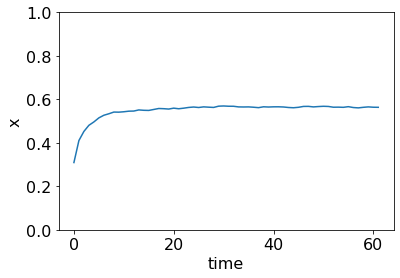

In [13]:
def f(x, alpha):
    """
    conformity response function. This is written such that x can be an array
    """  
    
    lowbranch = (2*x)**alpha/2
    highbranch =  1 - (2*(1-x))**alpha/2
    y = (x>=0)*(x<=0.5)*lowbranch + (x>0.5)*(x <=1)*highbranch
    
    return y


def _update_I_learner(A, n, m): 
    """
    update opinion matrix A as if everyone is an individual learner
    """
    
    A_i = copy.deepcopy(A)
    
    Dice = np.random.uniform(size = (n, n))
    
    idx0 = (A_i ==0 ) # get the index for where entries are 0
    idx1 = (A_i == 1) # 
    p_01 = m  # transition rate form opinion 0 to 1. 
    p_10 = 1.-m # transition rate from 1 to 0
    
    A_i[idx0 & (Dice < p_01)] = 1 # set those with value 0 to 1 with probability m. 
    A_i[idx1 & (Dice < p_10)] = 0
    
    return A_i


def _update_S_learner(A, alpha, n):
    """
    update opinion matrix A as if everyone is an social learner
    the grid has a period boundary condition
    """
    A_s = copy.deepcopy(A)
    
    # get the sum of neighbors by shifting matrix 4 directions and sum. 
    A_up = np.roll(A_s, -1, axis = 0) # rolls 1 up 
    A_down = np.roll(A_s, 1, axis = 0) # rolls 1 down
    A_left = np.roll(A_s, -1, axis = 1) # rolls 1 left 
    A_right = np.roll(A_s, 1, axis = 1) # rolls 1 right 
    
    neighborSum = (A_up +A_down + A_left+  A_right)

    idx0 = (A_s ==0 ) # get the index for where entries are 0
    idx1 = (A_s == 1 ) # get the index for where entries are 1
    
    p_01 = f(neighborSum/4, alpha) # transition probability from 0 to 1 
    p_10 = f(1- neighborSum/4, alpha) # transition probability form 1 to 0
    
   
    Dice = np.random.uniform(size = (n, n))
    
    A_s[idx0 & (Dice < p_01)] = 1 # opinon 0 transition to 1
    A_s[idx1 & (Dice < p_10)] = 0 # opinon 1 transition to 0
    
    return A_s
    

def update(A, B, m, n, alpha): 
    """
    Function that updates the belief matrix based on updating rules for 1 step
    Use matrix operation to update everyone at once
    A is belief matrix
    B is updating type matrix, 1 is individual learner, 0 is social learner
    Here the capital lettered variables are matrices. 
    A and B both need to be n by n matrices. 
    """
    
    A_i = _update_I_learner(A, n, m) # update everyone as if they're an individual learner
    A_s = _update_S_learner(A, alpha, n) # update everyone as if they're an social learner
    
    # index the two outputs by learning type matrix B, and combine results
    newA = A_i*(B == 1) + A_s*(B == 0) 
    
    return newA

def initilize(n, s, opthreshold):
    """
    input size of matrix and output initial A (opinion) and B (update type) matrix. 
    opthreshold =  portion of starting opinon of 1 
    s = portion of social learners. 
    in matrix b, 1 = individual learner, 0 = social learner. 
    """
    
    A = (np.random.uniform(size = [n, n])< opthreshold)*1
    B = (np.random.uniform(size = [n, n])< (1-s))*1

    return A, B


def runSim(tmax, m, n, alpha, s, x0, convTol, plotHist = 0): 
    """
    Runs the simulation with input paras
    output a and t. 
    plotHist: option to plot out the history of x. 
    """
    # initialize A and B. 
    A, B = initilize(n, s, x0)
    
    A_i = copy.deepcopy(A) # save a copy of initial opinion
    
    xList = []
    # set default values for output if the simulation did not converge. 
    flag = 0
    x = np.nan
    tCov = "inf" 
    
    # run simulation 
    for i in np.arange(tmax):
        A = update(A, B, m, n, alpha)
        xList.append(np.mean(A)) # list storing x over time. 
        converge, xmean,xstd= myfun.checkConverge(xList,tol = convTol)

        if converge == 1:
            tCov = i
            x =  xmean # portion of people with opinion 1 at convergence.  
            flag = 1 # a flag checking whether the code converged. 
            break
            
    if plotHist == 1: 
        plt.plot(xList)
        plt.ylim([0, 1])
        plt.xlabel("time")
        plt.ylabel("x")
               
    # output a dictionary saving the parameters and outputs. 
    return {"m":m, "s": s, "x": x, "tCov": tCov , "alpha": alpha, "IC":x0 , "flag" : flag, "opinion_i": A_i, "opinion_f": A}

    
# System Parameters. 
n = 200 #there are n*n individuals.  
s = 0.5 # portion of individual learners
m = 0.55 # merit of idea 1
alpha = 1.8

# --- Run 1 trial with Numerical parameters and plot trajectory ---- 
tmax= 2000
x0 = 0.1 # initial conditions
convTol =  0.002 # tolerance for convergence 
       
# do test run for 1 set of parameters
out = runSim(tmax, m, n, alpha, s, x0, convTol, plotHist =1)


Text(0.5, 1.0, 'final')

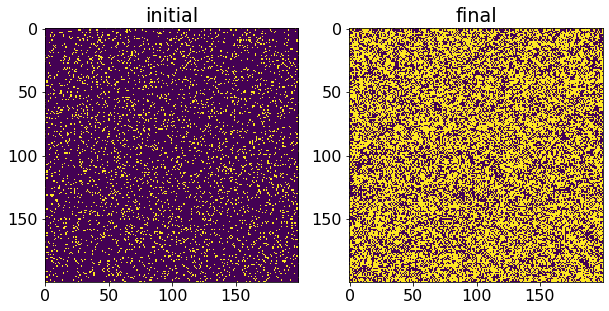

In [14]:
# Plot initial and final beliefs in spatial patterns
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title("initial")
plt.imshow(out["opinion_i"])

plt.subplot(1, 2, 2)
plt.imshow(out["opinion_f"])
plt.title("final")


### Loop through parameters

In [27]:
def run_multi_paras(sList, mList, x0List, alpha, n, tmax= 10000, convTol = 0.005): 
    """
    Run simulation with multiple parameters
    tmax : max simulation time
    convTol :convergence critieria
    """
    dicList = []
    for i, x0 in enumerate(x0List):
        x0 = x0List[i]
        for s in sList:
            if i == 0: 
                mOrder = mList
            elif i == 1:  # if trying to solve for upper branch, start with large m. 
                mOrder = np.flip(mList)
            for m in mOrder:
                out = runSim(tmax, m, n, alpha, s, x0, convTol, plotHist =0 )
                x0 = out["x"]
                dicList.append(out)
                if out["flag"] == 0:
                    print("warning: simulation didn not converge")
    return pd.DataFrame(dicList)


# --- Specify parameters for simulation 
mList = np.linspace(0, 1, 30)
x0List = np.array([0.05, 0.95])

alpha = 1.8
n = 200

# --- run the case of s = 0.5
sList1 = np.array([0.5])

res1 = run_multi_paras(sList1, mList, x0List, alpha, n, tmax= 10000, convTol = 0.002 )

In [30]:
# --- run the case of s = 0.95
sList2 = np.array([0.95])

res2 = run_multi_paras(sList2, mList, x0List, alpha, n, tmax= 10000, convTol = 0.002 )

Text(0, 0.5, 'x at steady state')

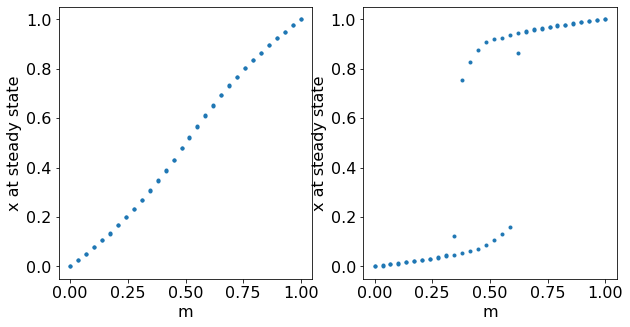

In [31]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)

plt.plot(res1.m, res1.x, ".")
plt.xlabel("m")
plt.ylabel("x at steady state")

plt.subplot(1, 2, 2)

plt.plot(res2.m, res2.x, ".")
plt.xlabel("m")
plt.ylabel("x at steady state")